Combined Spectral Clustering and Parallel KMeans++ with Python Implimentation
==========

Abstract
--------

Various clustering algorithms exist to identify and characterize groups of similar observations. Spectral clustering, as described by Ng et al. (2002), finds clusters among the rows of the matrix of eigenvectors of a scaled affinity matrix, assigning each observation to the cluster of its corresponding row. How to cluster these rows is left unspecified, but the authors give k-means clustering as an example. The clusters determined by the k-means algorithm depend on the initial cluster centers, but it is computationally expensive to repeatedly sample centers and rerun the algorithm, or to handpick optimal initial centers in sequence as in the k-means++ algorithm. To combat this inefficiency, Bahmani et al. (2012) presented a method to select a desirable set of initial centers in parallel, making k-means++ scalable to larger datasets. 

This project aims to combine these two methods in a single Python implementation, carrying out spectral clustering by selecting initial centers for k-means clustering among the rows of the matrix of eigenvectors of the affinity matrix using scalable k-means++. This combined algorithm is designed for intermediate datasets, for which finding the first k eigenvectors is still feasible but repeatedly sampling initial centers and rerunning already takes too long. In particular, this algorithm would perform best in datasets with contiguous, irregularly shaped clusters, for which spectral clustering preserves non-spherical boundaries and choosing an initial center in each cluster by scalable k-means++ produces near-optimal clusters much faster than randomly sampling initial centers from among all observations.

Algorithm
---------
K-means remains one of the most popular algorithm in clustering methods over the past decades. The advantage of k-means is its simplicity in implementing. however, this algorithm is not good enough in terms of clustering quality and efficiency. So recent work has been focused on finding better representation of the data and better initialization procedure. We choose to corporate spectral clustering with parallel version of k-means++ initialization method in to k-means algorithm so as to achieve better clustering.

### Algorithm Outline:
In the following description, assume a set of data points $X = {x_1, x_2, …, x_n}$ in the d dimensional space, and our objective is to divide them into k different clusters.

- Spectral Clustering
1.	Calculate the affinity matrix A , where ,   is a scaling parameter which can be manually assigned or selected during clustering procedure.
2.	Define a diagonal matrix D, whose i-th diagonal entry is the sum of A’s i-th row, and define .
3.	Find the k largest eigenvectors of L, , and form a matrix Z by horizontally stacking them in columns.
4.	Form matrix Y by normalizing each row of X so that each row in Y has unit norm, i.e.  
5.	Treat each row of Y as a new data point, and cluster them into k clusters via k-means.
6.	Assign the original point  to the same cluster as i-th row of Y.

- Parallel k-means++ 
Define a cost function of X with respect to the set of centers C as: $$\phi_Y(C) = \sum_{y\in Y}min_{i=1,2...,k}||y-c_i||^2$$
1.	First sample a single point uniformly at random from data set Y, add it to the center set C
2.	Calculate $\phi_y(C)$ and denote it as $\psi$
3.	Then update C iteratively. In each iteration, sample each points in Y independently, with inclusion probability of $p_y = \frac{ld^2(y,C)}{\phi_Y(C)} $, where $l$ is a oversampling factor chosen manually, $d^2(y,C) = min_{i=1,2...,k}||y-c_i||^2$. Then update the center set by adding all these newly chosen points. Repeat this for $O(log\psi)$ times.
4.	For each point x in the center set C, assign a weight $\omega_x$  that equals the number of points closer to x than any other points in C.
5.	Finally, recluster the weighted points in C into k clusters. That is generate $\omega_x$ copies of point x in C, and cluster them into k groups.


Algorithm Implimentation
----------------
### Spectral Clustering

In [1]:
#import os
#import sys
#import glob
import numpy as np
#import pandas as pd
#import operator as op
#import itertools as it
import scipy.linalg as la
from pandas import DataFrame, Series
#from functools import reduce, partial
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context("notebook", font_scale=1.5)

In [2]:
def testdata(n, k):
    """
    Make test dataset of 'n' points in 'k' concentric spirals in R^2
    """
    clus = np.random.randint(0, k, n)  # Cluster ID
    theta = np.random.uniform(0, np.sqrt(n / k**3), n) + 1  # Angle/radius
    xs = k * theta * np.cos(theta + 2 * np.pi * clus / k) + np.random.normal(0, np.pi/4, n)
    ys = k * theta * np.sin(theta + 2 * np.pi * clus / k) + np.random.normal(0, np.pi/4, n)
    return (np.column_stack([xs, ys]), clus)

In [3]:
def affinmat(pts, sigma=1):
    """
    Make scaled affinity matrix for points 'pts' using bandwidth 'sigma'
    """
    A0 = np.sum((pts[None, :] - pts[:, None])**2, -1)  # Squared distance matrix
    A = np.exp(-A0 / (2 * sigma**2))
    np.fill_diagonal(A, 0)  # Affinity matrix
    D12 = np.diag(1 / np.sqrt(np.sum(A, 1)))  # Row sums^(-1/2) for scaling
    return np.dot(np.dot(D12, A), D12)  # Scaled affinity matrix

In [4]:
def eigenmat(L, k=2):
    """
    Make scaled matrix of 'k' largest eigenvectors of scaled affinity matrix 'L'
    """
    n = L.shape[0]  # Number of points
    X = la.eigh(L, eigvals=(n - k, n - 1))[1][:, ::-1]  # k largest eigenvectors
    X1 = la.norm(X, axis=1)[:, None]  # Row norms for scaling
    return X / X1  # Scaled matrix of eigenvectors

In [5]:
def specprep(pts, k=2, sigma=1):
    """
    Prepare data for spectral clustering: convert points 'pts' into scaled
    matrix of 'k' largest eigenvectors of scaled affinity matrix with
    bandwidth 'sigma', ready for clustering by any method, e.g., k-means
    """
    L = affinmat(pts, sigma)  # Scaled affinity matrix
    Y = eigenmat(L, k)  # Scaled matix of k largest eigenvectors
    return(Y)

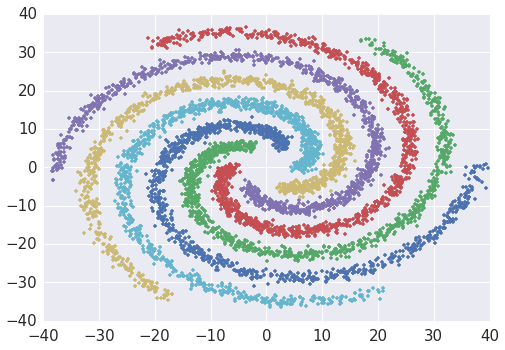

In [6]:
#### Create test dataset ####
n = 6144
k = 6
pts, clus = testdata(n, k)

#### Plot test dataset ####
for c in range(k):
    pc = np.array([pts[i] for i in range(n) if clus[i]==c])
    plt.plot(pc[:,0], pc[:,1], '.')
plt.show()

In [7]:
#### Time 'specprep' on test dataset ####
%time Y = specprep(pts, k, np.pi/4)

CPU times: user 2min 48s, sys: 7.89 s, total: 2min 56s
Wall time: 46.8 s


/opt/conda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


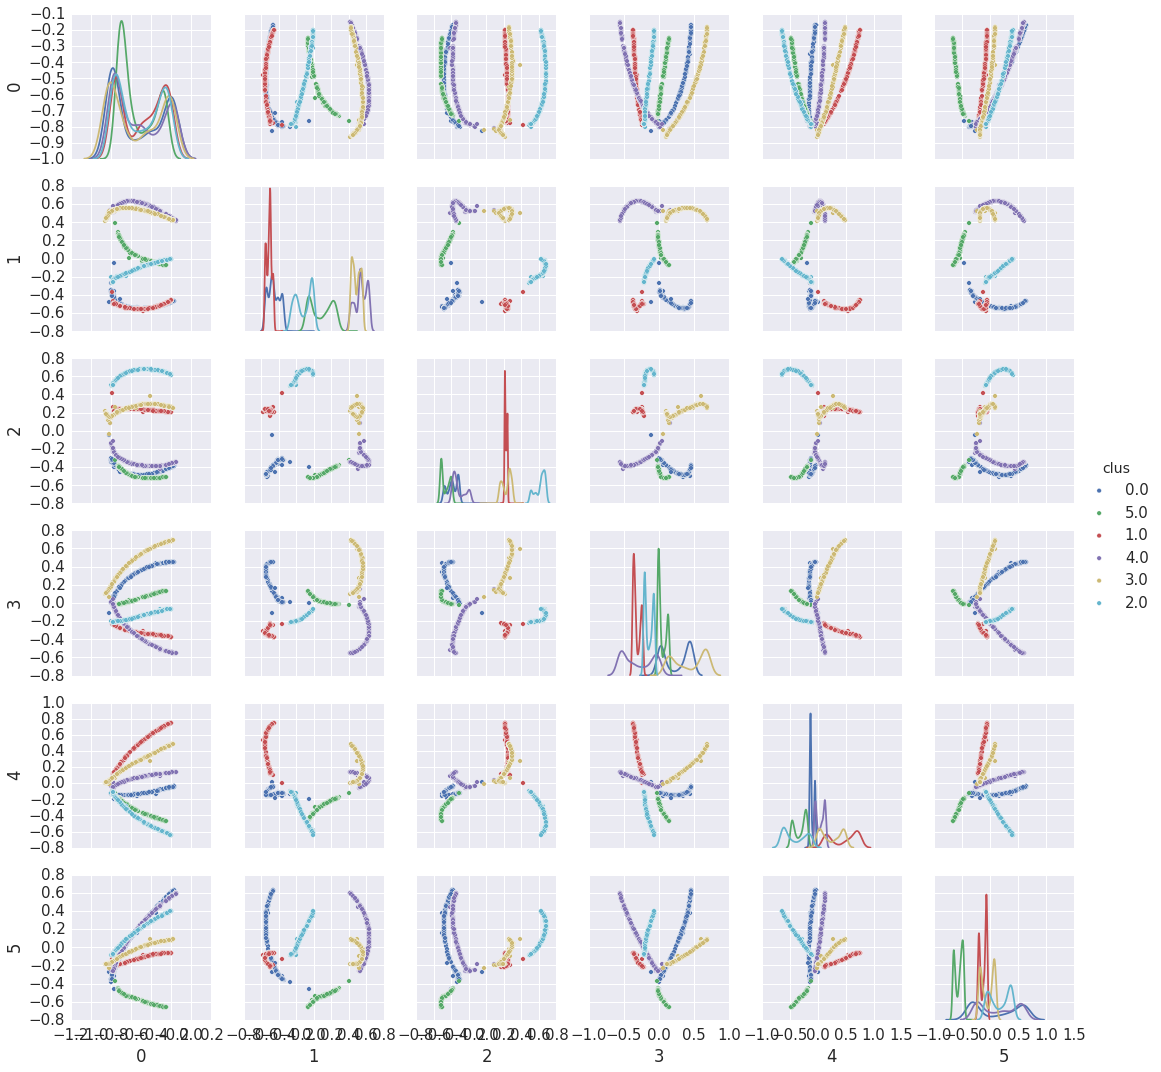

In [8]:
##### Plot first 2 dimensions to see transformed clusters ####
#for c in range(k):
#    Yc = np.array([Y[i] for i in range(n) if clus[i]==c])
#    plt.plot(Yc[:,0], Yc[:,1], '.')
#plt.show()

##### Plot first 3 dimensions to see transformed clusters ####
#from mpl_toolkits.mplot3d import Axes3D
#fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
#Axes3D.scatter(ax, xs=Y[:,0], ys=Y[:, 1], zs=Y[:,2], c=clus)

#### Plot pairwise scatter plots to see transformed clusters ####
df = DataFrame(data=np.column_stack([Y, clus]), columns=list(range(k))+["clus"])
sns.pairplot(df, hue="clus", vars=df.columns[:-1], diag_kind="kde")
pass


CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 6.2 µs


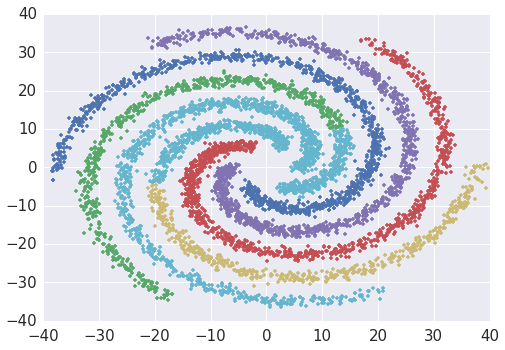

In [9]:
#### Try out K-Means on transformed data (separate from K-Means++ part of project) ####
%time
from sklearn.cluster import KMeans
km = KMeans(n_clusters=k, n_jobs=-1)
kmcl = km.fit_predict(Y)
for c in range(k):
    pc = np.array([pts[i] for i in range(n) if kmcl[i]==c])
    plt.plot(pc[:,0], pc[:,1], '.')
plt.show()


### Parallel Kmeans++
The parallel kmeans++ algorithm is implimented below. The coded function would first be implimented on a toy dataset, before eventually applied to the generated dataset in spectral clustering. 

In [10]:
import scipy.linalg as la
def phi(X, C):
    '''compute the cost function of data X with respect to centroid set C'''
    return np.sum([min([la.norm(x-c)**2 for c in C]) for x in X])

In [11]:
def num_closest(C,X):
    '''find the index of centroid that is closest to each data points in X'''
    d_mat = np.sum((C[None,:] - X[:,None])**2, -1)
    close = [np.argmin(d) for d in d_mat]
    return close
    

In [12]:
import scipy.stats as stats
from sklearn.cluster import KMeans
import numpy as np

def kmeans_paral(X, k, l, alpha = 1):  #alpha controls the number of iterations
    '''impliment Kmeans||'''
    C_idx = [np.random.choice(X.shape[0])]  #uniformly sample one point into the centroid set
    dist = phi(X,X[C_idx])
    max_it = int(alpha*np.log(dist))
    for it in range(max_it):
        Cprime = [i for i,x in enumerate(X) if stats.uniform().rvs(1)< l*phi(x,X[C_idx])/dist] #sample each data independently into centroid set
        C_idx = list(set(C_idx) | set(Cprime))
        dist = phi(X,X[C_idx])
    close = num_closest(X[C_idx],X)
    w = [list(close).count(c) for c in range(len(C_idx))] #calculate weight of each centroid
    re = sum([[j]*w[i] for i,j in enumerate(C_idx)],[])
    fit = KMeans(n_clusters = k).fit(X[re]) #recluster the weighted points into k clusters
    return fit.cluster_centers_
        

In [13]:
# Try out on a toy dataset
%time
data = "54.0 -65.0  0.0  71.0 -31.0  53.0  8.0 111.0  1.0  -9.0 -36.0  52.0 -22.0 -76.0  0.0  20.0 34.0 129.0 28.0  84.0 12.0 -38.0 -21.0 -26.0 -6.0 -41.0 21.0  45.0 38.0 -90.0 -24.0  10.0 -38.0  35.0 86.0 -57.0 58.0  -1.0 -9.0  -3.0 70.0 -74.0 -20.0  70.0 -43.0  44.0 59.0 -26.0 -5.0 114.0 83.0 -41.0 27.0 153.0 12.0 -49.0 30.0 -65.0 31.0 -12.0 -57.0  28.0 44.0 -28.0  7.0  -7.0 54.0  -8.0 65.0  -8.0 -35.0  25.0 46.0  79.0  5.0 118.0 56.0   4.0 -21.0  54.0 -40.0  45.0 -43.0  51.0 57.0 -21.0  0.0   0.0 25.0  15.0 56.0 -25.0 -34.0  56.0 -24.0  36.0 -25.0  49.0 64.0 -26.0 63.0 -48.0 37.0 155.0 -5.0 -24.0  2.0  28.0 -18.0 -58.0 -10.0  82.0 12.0 -58.0 -40.0 -28.0 -16.0  28.0"
X = np.array( [float(x) for x in data.split()]).reshape([-1,2])
init = kmeans_paral(X, 3, 2)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 6.68 µs


/opt/conda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


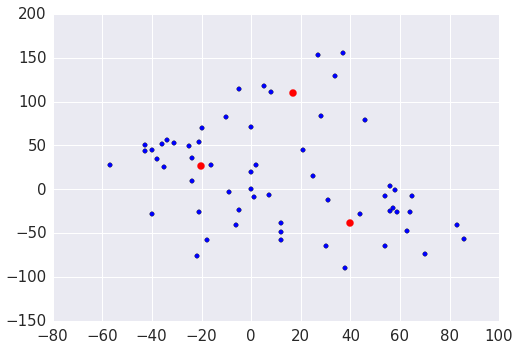

In [14]:
plt.scatter(X[:,0],X[:,1])
plt.scatter(init[:,0],init[:,1], marker='o',s=50,color='red')

In [15]:
#### Try out Parallel K-Means++ on transformed data ####
init = kmeans_paral(Y, 6, 6, 0.2)

CPU times: user 13 µs, sys: 1 µs, total: 14 µs
Wall time: 8.34 µs


/opt/conda/lib/python3.4/site-packages/sklearn/cluster/k_means_.py:821: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  n_jobs=self.n_jobs)


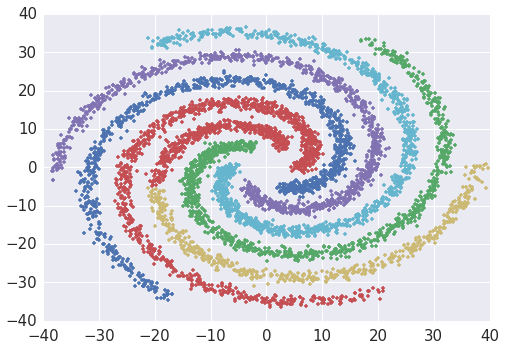

In [16]:
%time
from sklearn.cluster import KMeans
km = KMeans(n_clusters=k, init = init, n_jobs=-1)
kmcl = km.fit_predict(Y)
for c in range(k):
    pc = np.array([pts[i] for i in range(n) if kmcl[i]==c])
    plt.plot(pc[:,0], pc[:,1], '.')
plt.show()